# Solutions
Simulation results will be different. Check that your strategy for completing the exercises is similar to the sample solutions here.

## Exercise 1
Simulate January 2019

In [1]:
!python ../../ch_08/simulate.py 31 "2019-01-01" \
    -u ../../ch_08/user_data/user_base.txt \
    -i ../../ch_08/user_data/user_ips.json \
    -l jan_2019_log.csv \
    -hl jan_2019_attacks.csv

[INFO] [ simulate.py ] Simulating 31.0 days...
[INFO] [ simulate.py ] Saving logs
[INFO] [ simulate.py ] All done!


## Imports for Remaining Exercises

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Exercise 2
Find the number of unique usernames, attempts, successes, failures, and success/failure rates per IP address.

In [3]:
jan_log = pd.read_csv('jan_2019_log.csv', parse_dates=True, index_col='datetime')

log_aggs = jan_log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

log_aggs.head()

,source_ip,username,success,failures,attempts,success_rate,failure_rate
0,1.177.110.249,137,28.0,226.0,254.0,0.110236,0.889764
1,1.218.123.66,3,12.0,5.0,17.0,0.705882,0.294118
2,100.208.255.37,1,1.0,0.0,1.0,1.000000,0.000000
3,100.54.46.85,3,7.0,8.0,15.0,0.466667,0.533333
4,101.74.49.187,1,3.0,6.0,9.0,0.333333,0.666667


## Exercise 3
Create two subplots with failures versus attempts on the left and failure rate versus distinct usernames on the right. Draw a decision boundary for what you see. Be sure to color by whether or not it is a hacker IP.

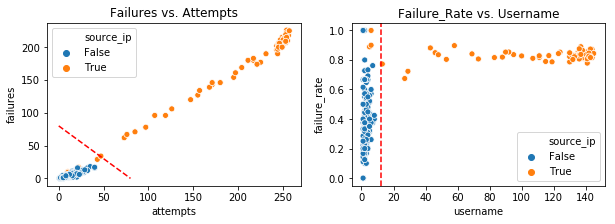

In [4]:
is_attack_ip = log_aggs.source_ip.isin(
    pd.read_csv('jan_2019_attacks.csv').source_ip
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, (x, y) in zip(axes, (
    ('attempts', 'failures'), ('username', 'failure_rate')
)):
    ax = sns.scatterplot(
        x=log_aggs[x], 
        y=log_aggs[y], 
        hue=is_attack_ip,
        ax=ax
    )
    ax.set_title(f'{y.title()} vs. {x.title()}')

# boundaries
axes[0].plot([0, 80], [80, 0], 'r--')
axes[1].axvline(12, color='red', linestyle='--')

## Exercise 4
Build an ensemble method of rule-based criteria using percent difference from the median, above the 95th percentile, and past the Tukey fence upper bound with a multiplier of 3 for failures, distinct usernames, and attempts. At least two must agree.

In [5]:
hourly_ip_logs = jan_log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

In [6]:
hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.177.110.249,2019-01-18 09:00:00,137,28.0,226.0,254.0,0.110236,0.889764
1,1.218.123.66,2019-01-01 09:00:00,1,1.0,0.0,1.0,1.000000,0.000000
2,1.218.123.66,2019-01-01 10:00:00,1,2.0,0.0,2.0,1.000000,0.000000
3,1.218.123.66,2019-01-02 13:00:00,1,1.0,0.0,1.0,1.000000,0.000000
4,1.218.123.66,2019-01-02 14:00:00,1,1.0,0.0,1.0,1.000000,0.000000


In [7]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """Calculate hourly statistic per column."""
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)
    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).groupby('hour').apply(
        lambda x: x.sample(10, random_state=0, replace=True).pipe(func, *args, **kwargs)
    )

In [8]:
medians = get_baselines(hourly_ip_logs, 'median')
p95 = get_baselines(hourly_ip_logs, 'quantile', .95)
q3 = get_baselines(hourly_ip_logs, 'quantile', .75).drop(columns=['hour'])
q1 = get_baselines(hourly_ip_logs, 'quantile', .25).drop(columns=['hour'])
iqr = q3 - q1
upper_bound = (q3 + 3*iqr).reset_index()

ensemble_ips = hourly_ip_logs.assign(
    hour=lambda x: x.datetime.dt.hour
).join(
    medians, on='hour', rsuffix='_median'
).join(
    p95, on='hour', rsuffix='_p95'
).join(
    upper_bound, on='hour', rsuffix='_tukey'
).assign(
    flag_median=lambda x: np.logical_and(
        np.logical_and(
            x.username_median * 4 <= x.username,
            x.attempts_median * 1.5 <= x.attempts
        ), x.failures_median * 1.5 <= x.failures
    ),
    flag_p95=lambda x: np.logical_and(
        np.logical_and(
            x.username_p95 <= x.username,
            x.attempts_p95 <= x.attempts
        ), x.failures_p95 <= x.failures
    ),
    flag_tukey=lambda x: np.logical_and(
        np.logical_and(
            x.username_tukey <= x.username, 
            x.attempts_tukey <= x.attempts
        ), x.failures_tukey <= x.failures
    ),
    flag_ensemble=lambda x: \
        x.flag_median.astype(int) \
        + x.flag_p95.astype(int) \
        + x.flag_tukey.astype(int) >= 2
).query('flag_ensemble').source_ip.drop_duplicates()

## Exercise 5
Calculate metrics to evaluate how well the ensemble method performed.

In [9]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IPs flagged as suspicious.
    
    Parameters:
        - alerted_ips: Pandas series of flagged IPs
        - attack_ips: Pandas series of attacker IPs
        - log_ips: Pandas series of all IPs seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = log_ips[log_ips.isin(alerted_ips)].isin(attack_ips).sum()
    fp = np.invert(
        log_ips[log_ips.isin(alerted_ips)].isin(attack_ips)
    ).sum()
    fn = np.invert(
        log_ips[log_ips.isin(attack_ips)].isin(alerted_ips)
    ).sum()
    return tp, fp, tn, fn

In [10]:
# make this easier to call
from functools import partial
scores = partial(
    evaluate, 
    attack_ips=pd.read_csv('jan_2019_attacks.csv').source_ip, 
    log_ips=jan_log.source_ip.drop_duplicates()
)

In [11]:
def classification_stats(tp, fp, tn, fn):
    """Calculate accuracy, precision, recall, and F1-score"""
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
    return {
        'accuracy' : (tp + tn) / (tp + fp + tn + fn),
        'precision' : precision,
        'recall' : recall,
        'F1-score' : f1_score
    }

In [12]:
classification_stats(*scores(ensemble_ips))

{'accuracy': 0.9487179487179487,
 'precision': 0.9367088607594937,
 'recall': 0.961038961038961,
 'F1-score': 0.9487179487179488}